In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.constants
from fytok.Tokamak import Tokamak
from fytok.modules.Equilibrium import Equilibrium
from fytok.utils.logger import logger
from spdm.view.View import display
from spdm.data.File import File
from spdm.data.Path import Path
from spdm.data.Entry import Entry
from spdm.view import View as sp_view
from spdm.data.Function import Function

WORKSPACE = "/home/salmon/workspace"  # "/ssd01/salmon_work/workspace/"
output_path = pathlib.Path(f"{WORKSPACE}/output/")

2024-01-11 21:45:09,005 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2024-01-11T21:45:08.796823.
 Job ID: fytok_salmon_surface_4430

###################################################################################################



In [2]:
data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")
astra_profiles = pd.read_excel(
    next(data_path.glob("*ASTRA.xls")).absolute().as_posix(), sheet_name=1, header=10, usecols="B:BN"
)
eqdsk_file = File(f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}", format="GEQdsk").read()

equilibrium = Equilibrium(
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium",
    # code={"parameters": {"psi_norm": np.linspace(0.01, 0.999, 128)}},
)

2024-01-11 21:45:09,460 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2024-01-11 21:45:09,570 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2024-01-11 21:45:09,605 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.fy_eq-FyTok 


2024-01-11 21:45:09,636 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:94:__init__: Create FyEquilibriumCoordinateSystem <FyEquilibriumCoordinateSystem name='coordinate_system' />
2024-01-11 21:45:09,642 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular
2024-01-11 21:45:09,708 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:132:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0
2024-01-11 21:45:11,260 [    spdm]     INFO: Load module spdm.view.view_matplotlib


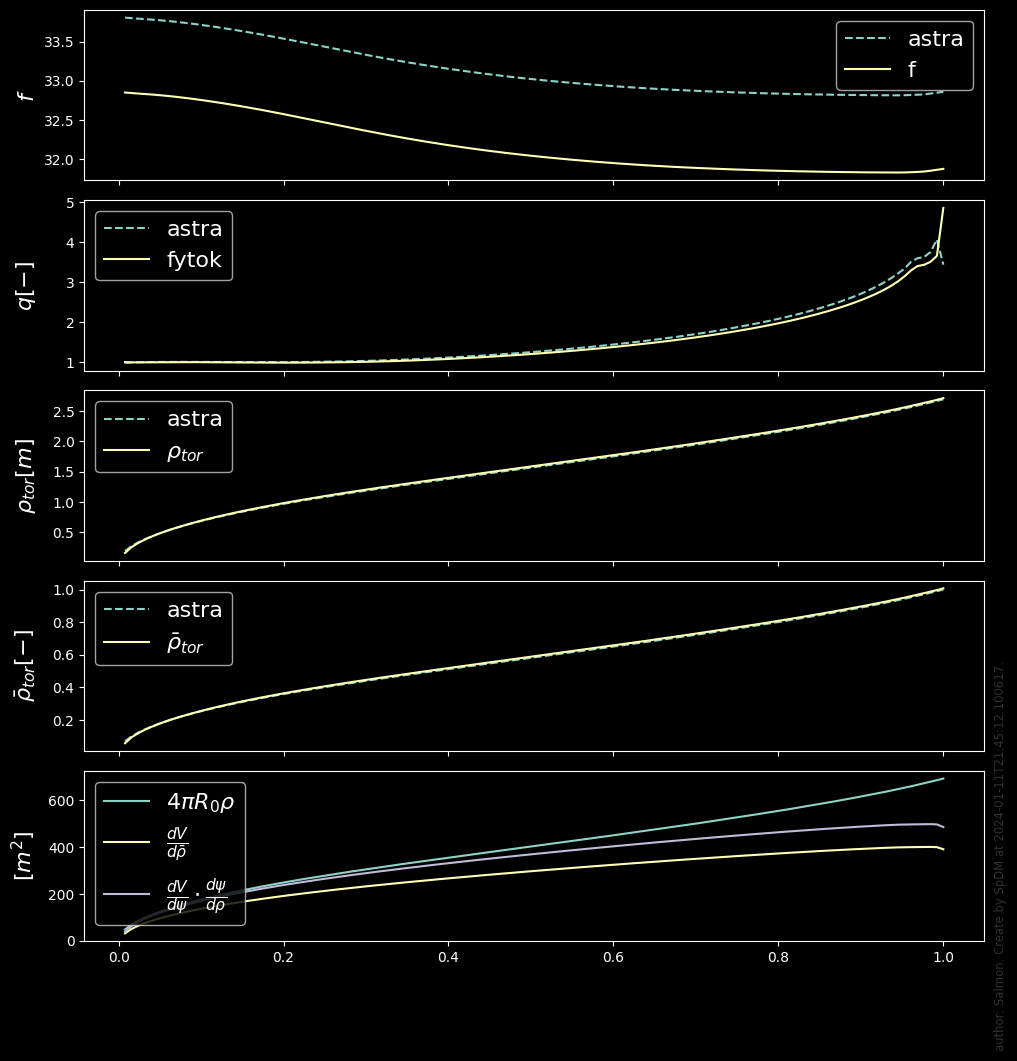

In [3]:
eq_profiles_1d = equilibrium.time_slice.current.profiles_1d
R0 = equilibrium.time_slice.current.vacuum_toroidal_field.r0
psi_axis=equilibrium.time_slice.current.global_quantities.psi_axis
psi_boundary=equilibrium.time_slice.current.global_quantities.psi_boundary

fig = sp_view.plot(
    eq_profiles_1d.psi_norm[1:],

    (
        [
            (
                Function(
                    eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/psi_norm"),
                    -eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/f"),
                ),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.f, "f"),
        ],
        {
            "y_label": r"$f$",
        },
    ),
    (
        [
            (
                Function(astra_profiles["xq"].values, astra_profiles["q"].values)(eq_profiles_1d.rho_tor_norm),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.q, {"label": r"fytok"}),
        ],
        {"y_label": r"$q [-]$"},
    ),
    (
        [
            (
                Function(astra_profiles["Fp"].values, astra_profiles["rho"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.rho_tor),
        ],
        {
            "y_label": r"$\rho_{tor}[m]$",
        },
    ),
    (
        [
            (
                Function(astra_profiles["Fp"].values, astra_profiles["x"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.rho_tor_norm),
        ],
        {
            "y_label": r"$\bar{\rho}_{tor}[-]$",
        },
    ),
    (
        [
            Function(
                astra_profiles["Fp"].values,
                4 * (scipy.constants.pi**2) * R0 * astra_profiles["rho"].values,
                label=r"$4\pi R_0 \rho$",
            ),
            (eq_profiles_1d.dvolume_drho_tor, {"label": r"$\frac{dV}{d\bar{\rho}}$"}),
            (
                (scipy.constants.pi * 2.0) * eq_profiles_1d.dvolume_dpsi * eq_profiles_1d.dpsi_drho_tor,
                r"$\frac{dV}{d\psi} \cdot \frac{d\psi}{d\rho}$",
            ),
        ],
        {"y_label": r"$[m^2]$"},
    ),
)

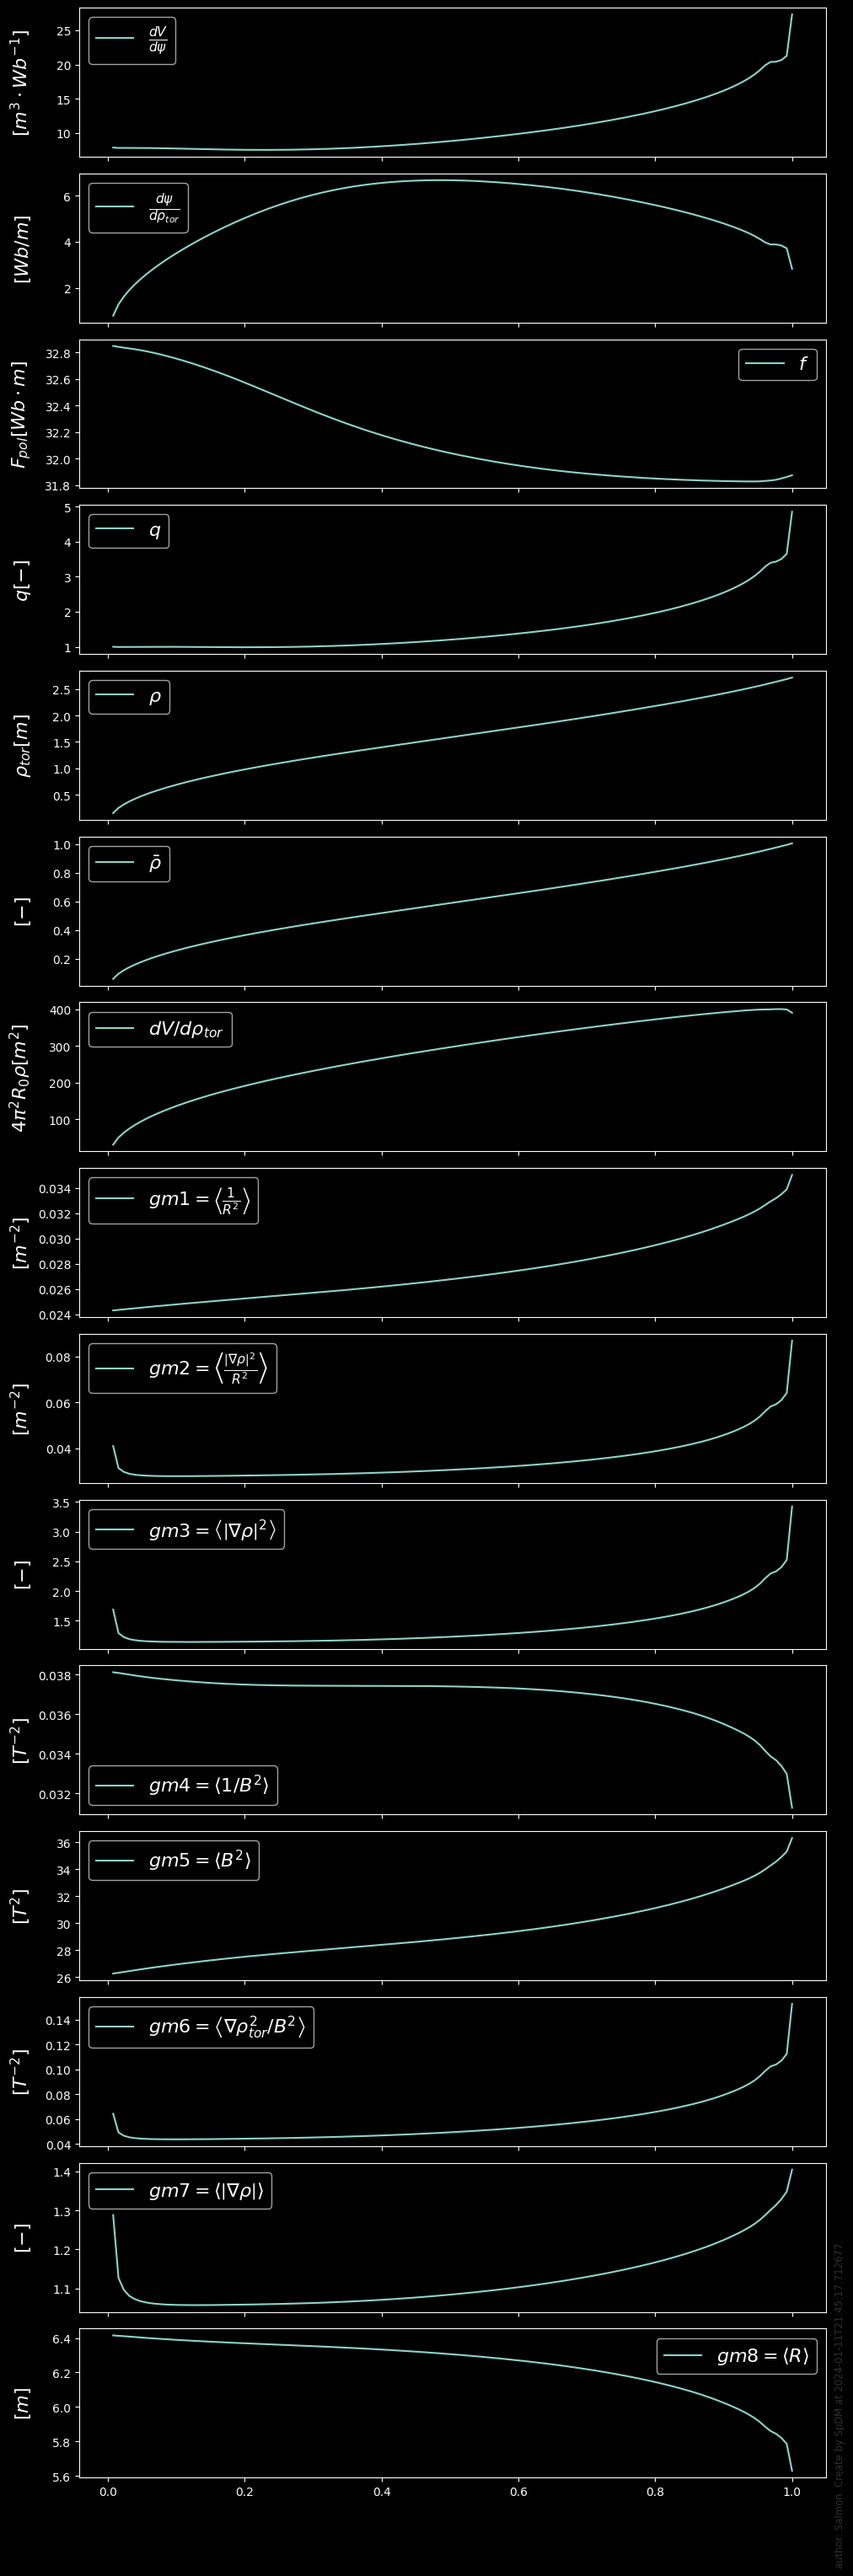

In [4]:
eq_profiles_1d = equilibrium.time_slice.current.profiles_1d
fig = sp_view.plot(  # plot tokamak geometric profile
    eq_profiles_1d.grid.psi_norm[1:],
    (eq_profiles_1d.dvolume_dpsi, r"$\frac{dV}{d\psi}$"),
    (eq_profiles_1d.dpsi_drho_tor, r"$\frac{d\psi}{d\rho_{tor}}$"),
    (eq_profiles_1d.f, {"y_label": r"$F_{pol} [Wb\cdot m]$"}),
    (eq_profiles_1d.q, {"y_label": r"$q [-]$"}),
    ((eq_profiles_1d.rho_tor, r"$\rho$"), {"y_label": r"$\rho_{tor}[m]$"}),
    ((eq_profiles_1d.rho_tor_norm, r"$\bar{\rho}$"), {"y_label": r"[-]"}),
    ((eq_profiles_1d.dvolume_drho_tor, r"$dV/d\rho_{tor}$"), {"y_label": r"$4\pi ^ 2 R_0 \rho[m ^ 2]$"}),
    (eq_profiles_1d.gm1, r"$gm1=\left<\frac{1}{R^2}\right>$"),
    (eq_profiles_1d.gm2, r"$gm2=\left<\frac{\left|\nabla \rho\right|^2}{R^2}\right>$"),
    (eq_profiles_1d.gm3, r"$gm3=\left<\left|\nabla \rho\right|^2\right>$"),
    (eq_profiles_1d.gm4, r"$gm4=\left<1/B^2\right>$"),
    (eq_profiles_1d.gm5, r"$gm5=\left<B^2\right>$"),
    (eq_profiles_1d.gm6, r"$gm6=\left<\nabla \rho_{tor}^2/ B^2 \right>$"),
    (eq_profiles_1d.gm7, r"$gm7=\left<\left|\nabla \rho\right|\right>$"),
    (eq_profiles_1d.gm8, r"$gm8=\left<R\right>$"),
)